# Clasificación usando Árbol de decisión

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Abril de 2024  
**Versión:** 1.0  

**Fecha de actualización:** Enero de 2025  
**Versión:** 1.1  


---

## Descripción

Este notebook contiene la explicación de la creación de un modelo de clasificación usando DecisionTreeClassifier.

Utiliza un conjunto de datos de predicción de diabetes. Este conjunto de datos contiene una serie de parámetros fisiológicos de un paciente.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

# Árboles de decisión



---


Los árboles de decisión son métodos de aprendizaje de máquinas muy utilizados debido a su buen rendimiento y su explicabilidad. Un árbol de decisión no siempre tiene buen rendimiento, por lo que se proponen técnicas de ensamble de árboles de decisión aislados para generar un estimador más robusto que el estimador único por el que está conformado el ensamble.



---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report

In [ ]:
!wget https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv

--2025-04-22 16:35:22--  https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11 [following]
--2025-04-22 16:35:22--  https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5bded9943faf49ed62d431ebde.dl.dropboxusercontent.com/cd/0/inline/CoRHfPl5jb_3W7GslYzVm0YpW7SHNVcLSlqXEcyp-Hq2rF0cUeBrWTyV6XgB7ohMF1LgnUp2a520uYgvhNO3htq3rN6MBddFOdtZ87m28dLrxF2A38_VSVJUxGcpvEpHlr81l5Nefjv9X7dp5ksBDK3u/file# [following]
--2025-04-22 16:35:22--  https://uc5bded9943faf49ed62d431ebde.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

In [ ]:
diabetes.sample(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
446,1,100,72,12,70,25.3,0.658,28,0
158,2,88,74,19,53,29.0,0.229,22,0
274,13,106,70,0,0,34.2,0.251,52,0
598,1,173,74,0,0,36.8,0.088,38,1


Para ilustrar la construcción de un árbol de decisión utilizaremos sólo un par de variables del conjunto de datos.

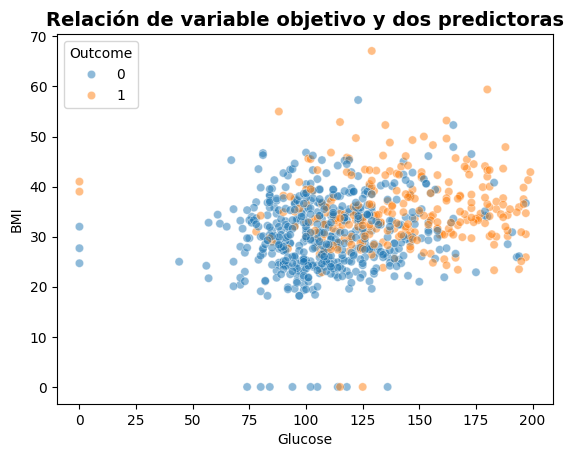

In [ ]:
sns.scatterplot(
    data = diabetes,
    x = "Glucose",
    y = "BMI",
    hue = "Outcome",
    alpha = 0.5
)
plt.title("Relación de variable objetivo y dos predictoras", fontsize=14, fontweight="bold")
plt.show()

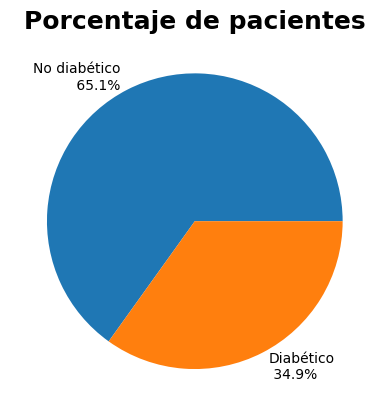

In [ ]:
# Gráfico de tortas del porcentaje de pacientes
clases = np.array([diabetes[diabetes.Outcome == 0.0].shape[0],
                   diabetes[diabetes.Outcome == 1.0].shape[0]])

# Creando las leyendas del gráfico.
labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No diabético\n ' + labels[0]
labels[1] = 'Diabético\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Porcentaje de pacientes', fontsize=18, fontweight="bold")
plt.show()

# Árbol de decisión

Para la construcción de un árbol de decisión, primero se debe definir una métrica a optimizar. En el caso de los árboles de decisión, una métrica que se puede
optimizar es la *entropía*. En donde a medida que se van tomando decisiones se busca ganar información o disminuir la entropía.

La definición de entropía a utilizar es la siguiente:

$$
H(X)=- \sum_{i}p(x_i) \log_2 p(x_i)
$$

Donde $X$ es el conjunto de etiquetas.

In [ ]:
def entropy(data : np.array) -> float:
  classes = np.unique(data)
  entropies = []
  for c in classes:
    p = sum(data == c) / len(data)
    current_entropy = p * np.log2(p)
    entropies.append(current_entropy)
  return -1 * sum(entropies)

Para comenzar, se puede estimar la entropía total del conjunto de datos

In [ ]:
entropy(diabetes.Outcome)

np.float64(0.9331343166407831)

Ahora, se debe tomar una decisión, con la cual se busca disminuir la entropía de cada uno de los subconjuntos obtenidos posterior a la decisión.

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose >= 175])

np.float64(0.6699960320994333)

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose < 175])

np.float64(0.8941290186253704)

Para estimar la entropía general de la decisión que se ha tomado se debe calcular un promedio ponderado de cada una de las entropías de cada subconjunto de datos.

In [ ]:
def weighted_entropy(data : pd.DataFrame, feature : str, label : str, threshold : int):
  indices = data[feature] >= threshold
  entropy_0 = entropy(data[label][indices])
  entropy_1 = entropy(data[label][~indices])
  return entropy_0 * (sum(indices) / len(indices)) + entropy_1 * (sum(~indices) / len(indices))


In [ ]:
weighted_entropy(diabetes, "Glucose", "Outcome", 175)

np.float64(0.8774941485316485)

Para determinar la mejor variable y el mejor umbral para la decisión del nodo del árbol se debe **optimizar** la ganancia de información de la decisión con la siguiente definición:

$$
IG(Y,X) = E(Y) - E(Y|X)
$$

Donde a la entropía total del conjunto de datos $E(Y)$ se le resta la entropía promedio $E(Y|X)$ de la decisión $Y$.

In [ ]:
entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", 175)

np.float64(0.055640168109134525)

Se calculan las entropías asociadas a un barrido de umbrales en un par de variables.

In [ ]:
glucose_information_gain_sweep = []
glucose_thresholds = np.linspace(diabetes.Glucose.min(), diabetes.Glucose.max(), 100)
for threshold in glucose_thresholds:
  glucose_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", threshold))

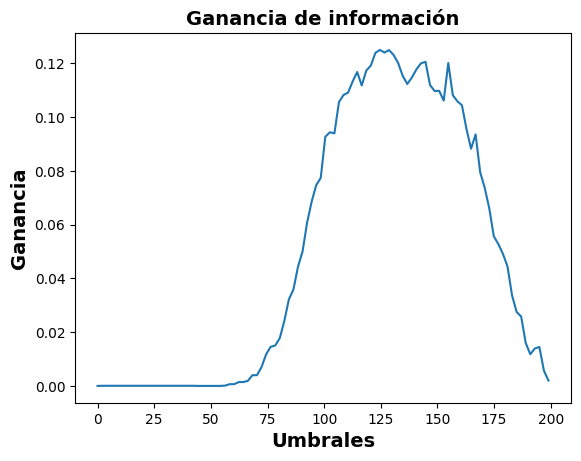

In [ ]:
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep
)
plt.title("Ganancia de información", fontsize=14, fontweight="bold")
plt.xlabel("Umbrales", fontsize=14, fontweight="bold")
plt.ylabel("Ganancia", fontsize=14, fontweight="bold");

In [ ]:
bmi_information_gain_sweep = []
bmi_thresholds = np.linspace(diabetes.BMI.min(), diabetes.BMI.max(), 100)
for threshold in bmi_thresholds:
  bmi_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "BMI", "Outcome", threshold))

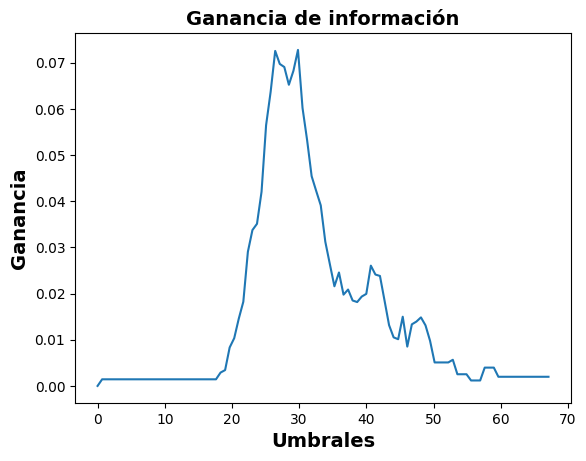

In [ ]:
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep
)
plt.title("Ganancia de información", fontsize=14, fontweight="bold")
plt.xlabel("Umbrales", fontsize=14, fontweight="bold")
plt.ylabel("Ganancia", fontsize=14, fontweight="bold");

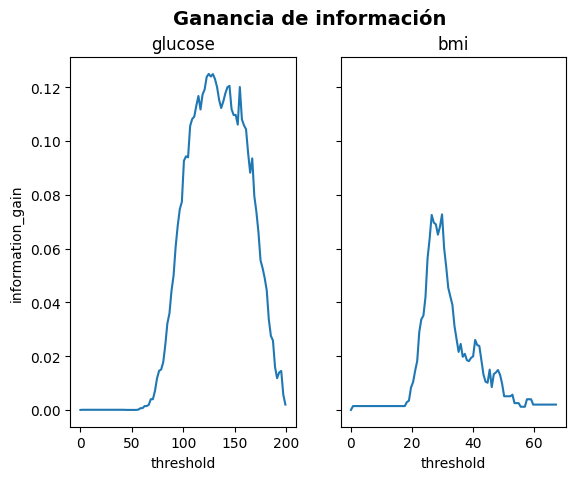

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2, sharey=True)
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep,
    ax = axs[0]
)
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep,
    ax = axs[1]
)
axs[0].set_title("glucose")
axs[1].set_title("bmi")
axs[0].set_ylabel("information_gain")
axs[0].set_xlabel("threshold")
axs[1].set_xlabel("threshold")
plt.suptitle("Ganancia de información",fontsize=14, fontweight="bold");

Selecciona el umbral que aporta la mayor ganancia de información.

In [ ]:
optimal_glucose_threshold = glucose_thresholds[np.argmax(glucose_information_gain_sweep)]
optimal_glucose_threshold

np.float64(124.62626262626262)

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose >= optimal_glucose_threshold])

np.float64(0.9773203829731114)

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose < optimal_glucose_threshold])

np.float64(0.6930190480473644)

Se utiliza la implementación del árbol de decisión de sklearn para calcular la misma decisión.

In [ ]:
single_decision = DecisionTreeClassifier(max_depth=1, criterion = "entropy")
single_decision = single_decision.fit(diabetes[["Glucose", "BMI"]], diabetes.Outcome)

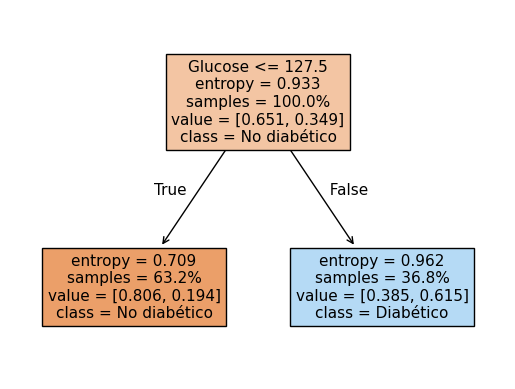

In [ ]:
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    single_decision, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = ["Glucose", "BMI"], # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Se prepara el conjunto de datos para poder ajustar un árbol de decisión de mayor profundidad.

In [ ]:
diabetes_features = diabetes.iloc[:,:-1]
diabetes_label = diabetes.Outcome

In [ ]:
(
    diabetes_features_train,
    diabetes_features_test,
    diabetes_label_train,
    diabetes_label_test
) = train_test_split(diabetes_features, diabetes_label, test_size=0.2, random_state=29, stratify=diabetes_label)

In [ ]:
tree = DecisionTreeClassifier( # Instanciamos el árbol de decisión.
    max_depth=3, # Fuerzas a que el árbol sólo tenga 3 niveles de profundidad.
    criterion = "entropy"
    )
tree.fit( # Ajusta el árbol de decisión.
    diabetes_features_train,
    diabetes_label_train
)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Calcula el rendimiento del árbol de decisión.

In [ ]:
print(classification_report(
    diabetes_label_test,
    tree.predict(diabetes_features_test), target_names=["No diabético","Diabético"]
))

              precision    recall  f1-score   support

No diabético       0.75      0.94      0.83       100
   Diabético       0.79      0.41      0.54        54

    accuracy                           0.75       154
   macro avg       0.77      0.67      0.68       154
weighted avg       0.76      0.75      0.73       154



Visualiza el árbol de decisión.

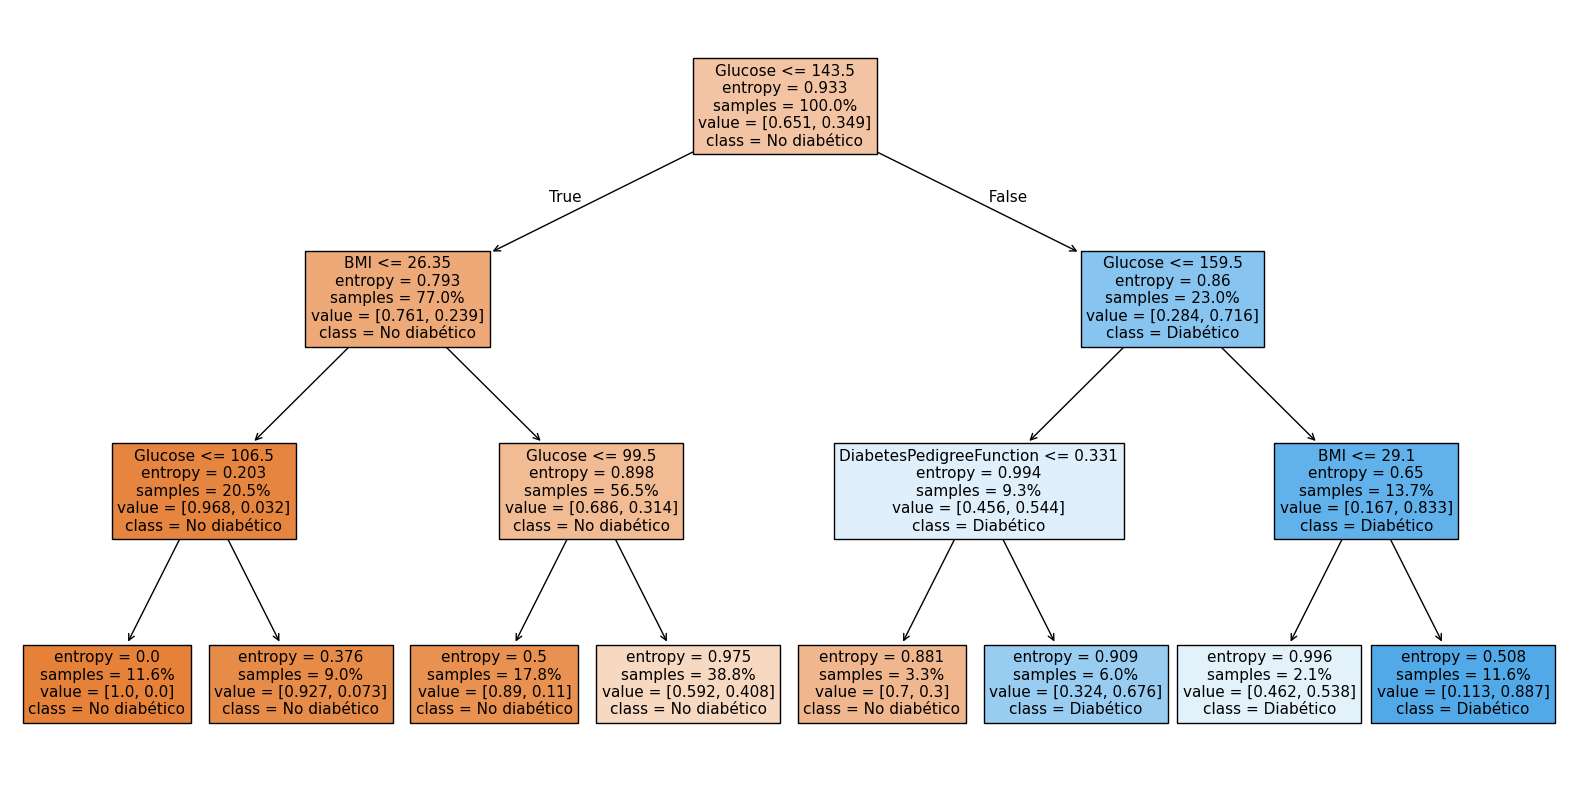

In [ ]:
plt.figure(figsize = (20,10))
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    tree, # Objeto que representa el árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que se están prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = True, # Visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

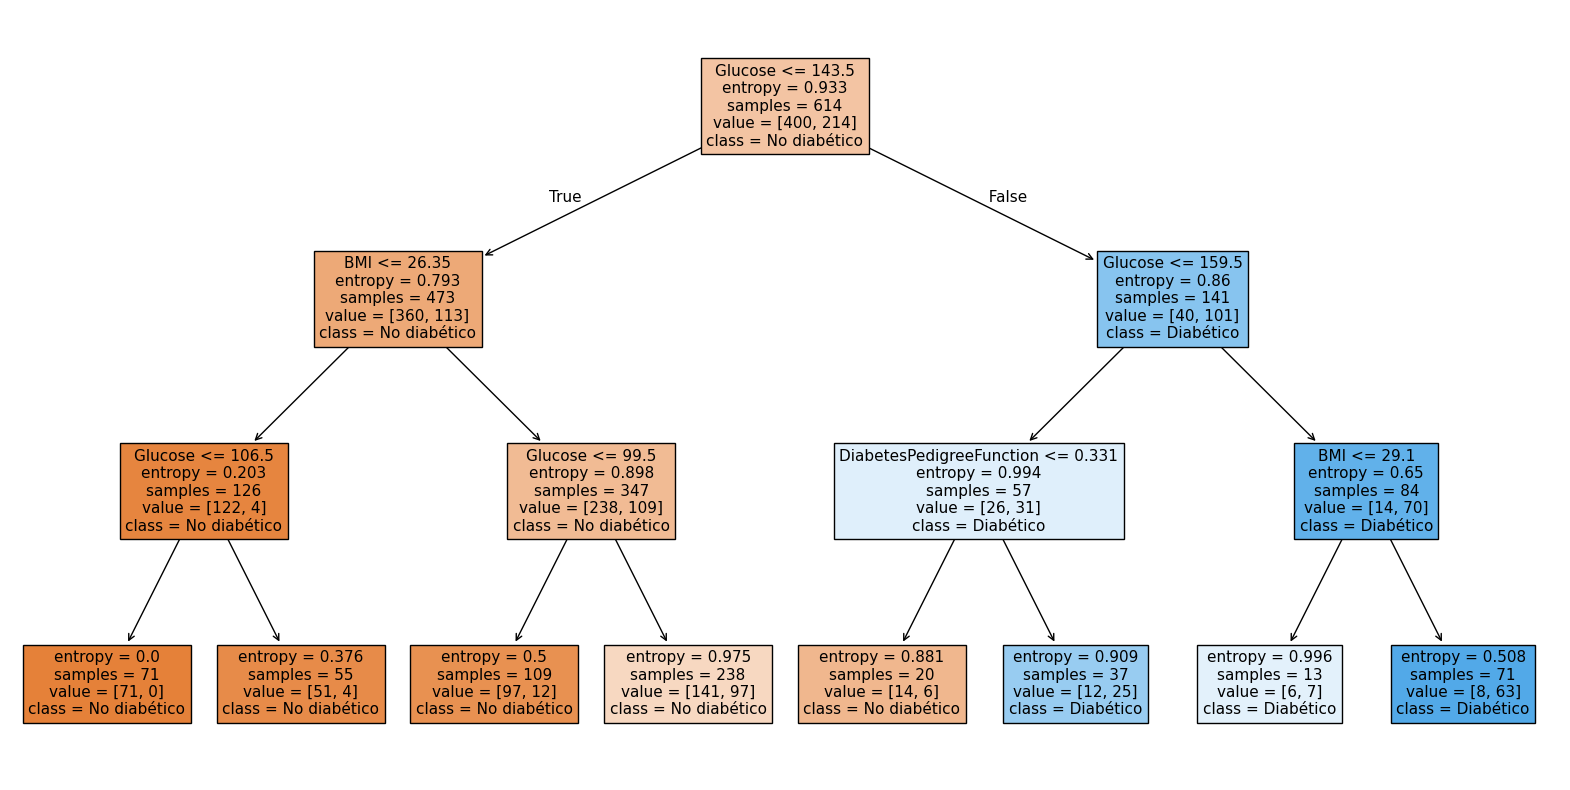

In [ ]:
plt.figure(figsize = (20,10))
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    tree, # Objeto que representa el árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que se están prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = False, # Visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Un hiperparámetro que es posible ajustar en un árbol de decisión es la **profundidad máxima**. Se visualiza que se tiene un mejoramiento inicial del rendimiento al aumentar la profundidad, para después descender debido al sobreajuste.

In [ ]:
depths = range(1,10)
performances = []
for depth in depths:
    current_tree = DecisionTreeClassifier( # Instancia el árbol de decisión.
        max_depth=depth,
        criterion = "entropy"
    )
    roc_auc = cross_val_score(
          current_tree,
          diabetes_features,
          diabetes_label,
          scoring="roc_auc"
      ).mean()
    performances.append(roc_auc)

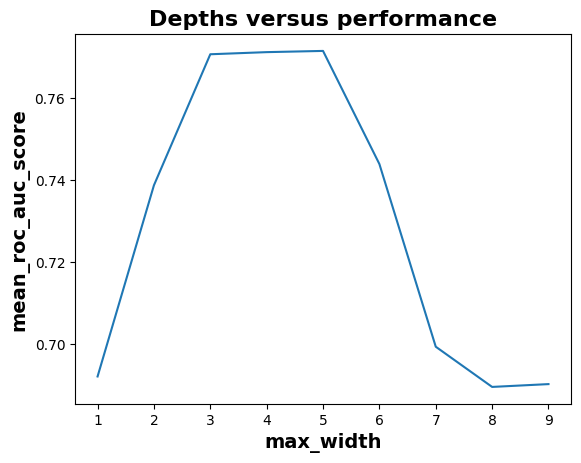

In [ ]:
plt.plot(
    depths,
    performances
)
plt.xlabel("max_width", fontsize=14, fontweight="bold")
plt.ylabel("mean_roc_auc_score", fontsize=14, fontweight="bold")
plt.title("Depths versus performance", fontsize=16, fontweight="bold")
plt.show()

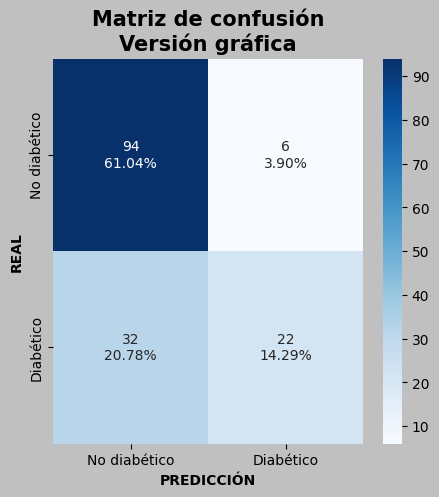

In [ ]:
# Matriz de confusión de forma gráfica
matriz = confusion_matrix(diabetes_label_test, tree.predict(diabetes_features_test))
plt.figure(figsize=(5,5),facecolor= 'silver')
clases = ["No diabético","Diabético"]
group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
# Calcula porcentajes
group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Genera la gráfica
sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión\nVersión gráfica", fontsize=15, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=10, fontweight="bold")
plt.ylabel("REAL", fontsize=10, fontweight="bold")
plt.show()